In [2]:
import numpy as np
from math import floor, ceil
from skimage.io import imread, imshow 
from skimage.transform import resize
from keras.models import load_model
from tensorflow.python.client import device_lib
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

Using TensorFlow backend.


In [13]:
# Defining constants
size = (480,480,3)
window_size = 128
stride = 16 
size_in = (ceil((size[0] - window_size + 1)/stride), ceil((size[1] - window_size + 1)/stride))
surpression_size = floor(window_size/stride/2)

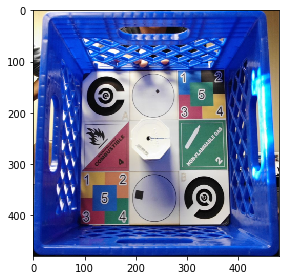

In [14]:
# This is a sample image of the robocup competition
from skimage.color import rgba2rgb
img = imread("real.png")
img = rgba2rgb(img)
img = resize(img, (size[0], size[1]))
imshow(img)

In [15]:
# Prevent memory hog by allowing gpu to grow
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
set_session(sess)
# Print available devices to make sure GPU is detected by TensorFlow
print(device_lib.list_local_devices())
# Load the model I trained
model = load_model('workingdistro0_1')
print("Model Loaded")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7873268859144109575
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7353932186
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7567965153209447489
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Model Loaded


In [16]:
# Non-max surpression
# Because there is always 2 hazmat labels, non-max surpression is used first to get rid of overlapping predictions
# Then, only the max 2 labels is chosen
def nms_predict(model, img):
    # Generate each frame X to put in
    left_corners = []
    X = np.zeros(((size_in[0]*size_in[1]), window_size, window_size, 3))
    for i in range(0, size[0] - window_size, stride):
        for j in range(0, size[1] - window_size, stride):
            left_corners.append((i, j))
    k = 0
    for i in range(0, size[0] - window_size, stride):
        for j in range(0, size[1] - window_size, stride):
            X[k,:,:,:] = img[i:i + window_size, j:j + window_size, :]
            k += 1
    
    # Predict each frame of the image
    Y = model.predict(X)
    Y = Y.reshape((size_in[0], size_in[1], 63))

    # Retrieve maxes and argmaxes
    maxes = np.max(Y, axis=2)
    argmaxes = np.argmax(Y, axis=2)
    
    # Surpress those without a label
    maxes = np.multiply(maxes, (argmaxes != 62))
    surpressed_maxes = []
    
    # Does NMS, but only pick the 2 most likely
    i = 0
    while i < 2:
        max_index = np.unravel_index(np.argmax(maxes), size_in)
        surpressed_maxes.append(max_index)
        a = max(max_index[0] - surpression_size, 0)
        b = min(max_index[0] + surpression_size, size_in[0])
        c = max(max_index[1] - surpression_size, 0)
        d = min(max_index[1] + surpression_size, size_in[1])
        maxes[a : b, c : d] = 0.
        i += 1
    
    # Plot the result
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    print("Red: {} ({})".format(np.argmax(Y[surpressed_maxes[0]]), np.max(Y[surpressed_maxes[0]])))
    print("Green: {} ({})".format(np.argmax(Y[surpressed_maxes[1]]), np.max(Y[surpressed_maxes[1]])))
        
    d =  (surpressed_maxes[0][1] * stride, surpressed_maxes[0][0] * stride)
    rectangle = patches.Rectangle(d, window_size , window_size,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rectangle)

    d =  (surpressed_maxes[1][1] * stride, surpressed_maxes[1][0] * stride)
    rectangle = patches.Rectangle(d, window_size , window_size,linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rectangle)
    
    plt.show()


Red: 48 (1.0)
Green: 43 (0.9999960660934448)


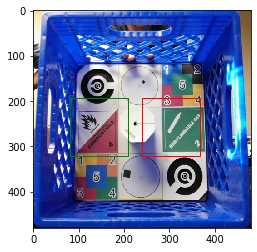

0.36697816848754883


In [27]:
start = time.time()
nms_predict(model, img)
end = time.time()
print(end - start)

The model detected 2 hazmat lables of label "48 and "43" corresponding to the red and green outline boxes with probability 1.0 and 0.9999960660934448.

In [3]:
pics = np.load("pics.npy")

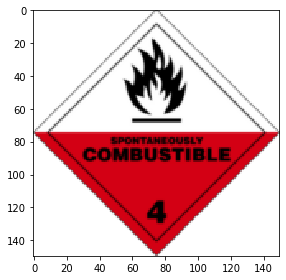

In [4]:
# The label "48" corresponds to the correct hazmat label
imshow(pics[48])

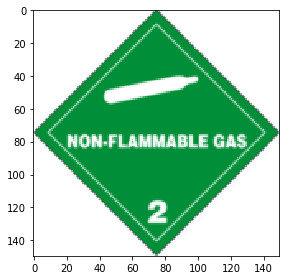

In [5]:
# The label "48" corresponds to the correct hazmat label
imshow(pics[43])